In [1]:
import pandas as pd
import dask
dask.config.set(scheduler="processes")
import matplotlib.pyplot as plt
import numpy as np
import re
import glob

# Loading the data

In [24]:
signal = "trade"
stock = "MSFT"
market = "B"
markets=["B","C","DF","II","MW","O","OQ","P"]

files = glob.glob(f"./Data/{signal}\\{stock}.{market}\\*.csv.gz")

print(f"signal : {signal},  #files : {len(files)}, stock: {stock}, market:{market}")

def convert_time(df):
    df.index = pd.to_datetime(df["xltime"],unit="d",origin="1899-12-30",utc=True)
    return df
# open_time  = "09:30:00"
# close_time = "16:00:00"
def load_trade_file(file):
    res = pd.read_csv(file,compression="gzip")
    res = convert_time(res)
    res = res[res["trade-stringflag"] == "uncategorized"]
    return res[["trade-price"]]

def load_bbo_file(file):
    res = pd.read_csv(file,compression="gzip").rename(columns={"bid-price":"bid"})
    res = convert_time(res)
    res = res[res.bid>0]
    #res = res.bid.diff(1).dropna()>0 
    return res[["bid"]]

def load_daily_data(date):
    daily_data = {}
    for market in markets:
        try : 
            path = glob.glob(f"./Data/{signal}\\{stock}.{market}\\{date}*.csv.gz")[0]
            daily_data[market] = load_trade_file(path)
        except :
            print(f"missing data : {date} {market}")
    return daily_data

signal : trade,  #files : 251, stock: MSFT, market:B


In [58]:
date = '2010-01-04'
daily_data = load_daily_data(date)

# Signal visu

In [87]:
def generate_delayed_data(s1,s2,delay):
    
    s1.index = s1.index + +pd.Timedelta(milliseconds=delay) 
    pair_data = s1.join(s2,how = "outer",lsuffix="_1",rsuffix="_2").ffill().dropna()
    
    return pair_data

def compute_correlation(pair_data):
    corr = np.corrcoef(pair_data["trade-price_1"].values, pair_data["trade-price_2"].values)[0][1]
    return corr

def visualize_delay(n1,n2,delay,n_samples=1000):
    s1,s2 = daily_data[n1].copy(),daily_data[n2].copy()
    pair_data = generate_delayed_data(s1,s2,delay)
    corr      = compute_correlation(pair_data)
    
    plt.plot(pair_data["trade-price_1"][:n_samples])
    plt.plot(pair_data["trade-price_2"][:n_samples])
    plt.title(f"delay:{delay}ms, market1:{n1}, market2:{n2}, corr={corr:0.5f}")
    plt.show()

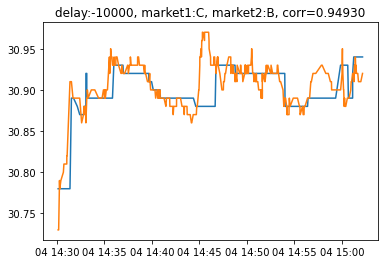

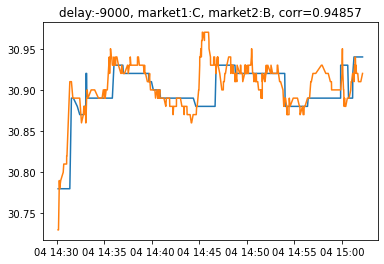

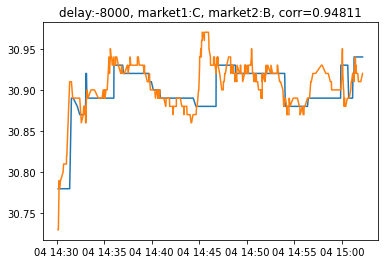

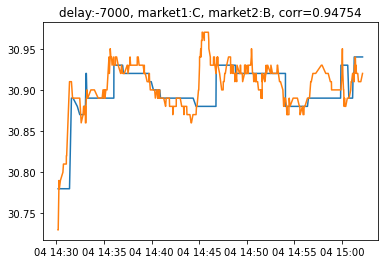

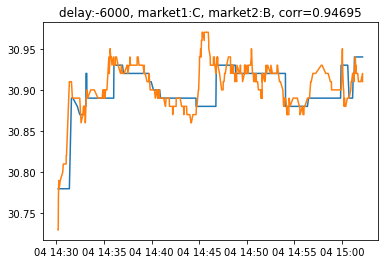

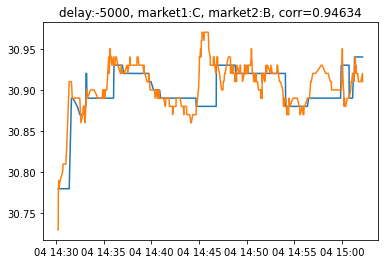

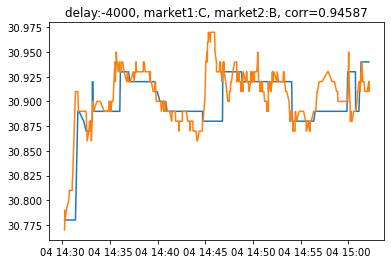

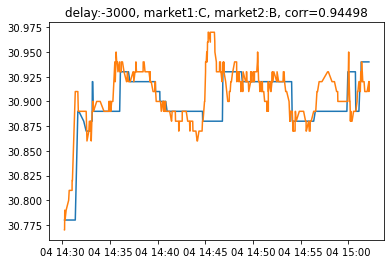

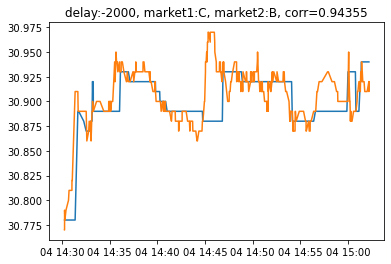

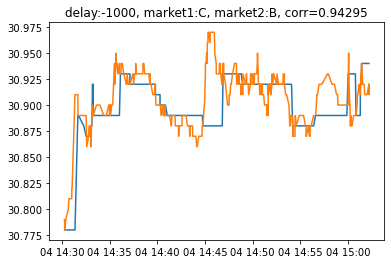

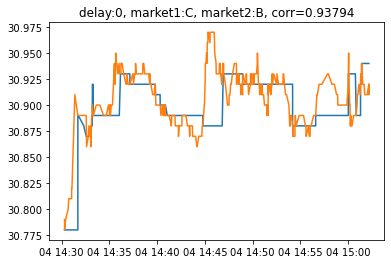

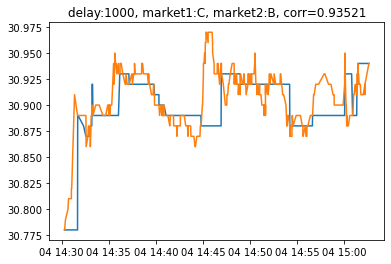

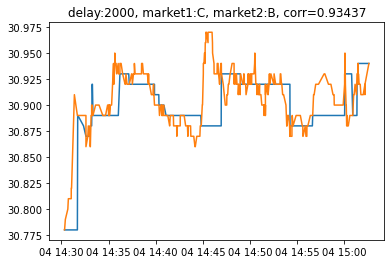

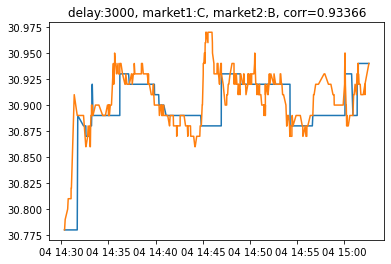

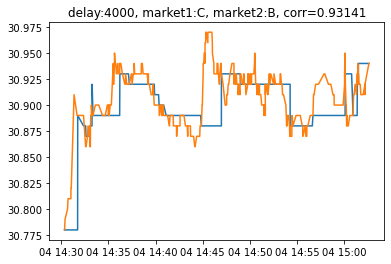

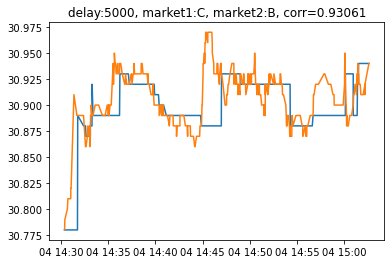

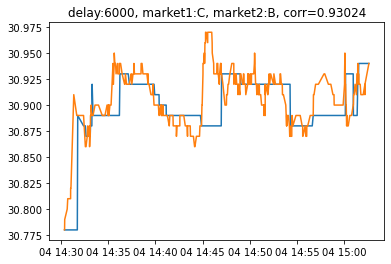

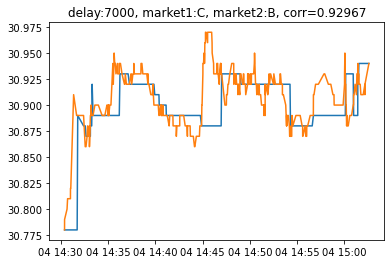

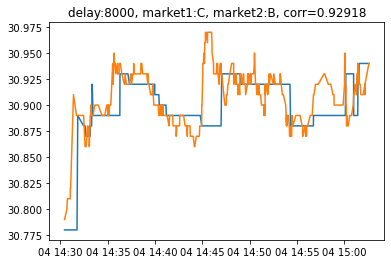

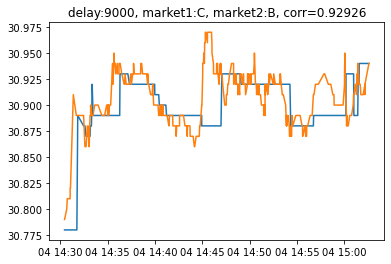

In [88]:
step = 1_000 #ms
delays = range(-10*step,10*step,step)
for delay in delays:
    visualize_delay(n1="C",n2="B",delay=delay)

# Correlation computation

In [27]:
market1_name = "B"
market2_name = "C"
pair_name = f"{market1_name}_{market2_name}"

In [28]:
def compute_correlation(daily_data,market1_name,market2_name,delay):
    market1_data = daily_data[market1_name].copy()
    market2_data = daily_data[market2_name].copy()
    
    market1_data.index = market1_data.index + +pd.Timedelta(microseconds=delay)
    
    pair_data = market1_data.join(market2_data,how = "outer",lsuffix="_1",rsuffix="_2").ffill().dropna()
    
    corr = np.corrcoef(pair_data["trade-price_1"].values, pair_data["trade-price_2"].values)[0][1]
    
    return corr

In [29]:

correlations = []
for delay in delays:
    corr = compute_correlation(daily_data,market1_name,market2_name,delay)
    correlations.append(corr)

# Visu

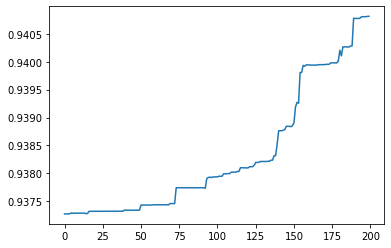

In [30]:
plt.plot(correlations)